In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
pip install mtcnn

     |████████████████████████████████| 2.3 MB 777 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [3]:
from mtcnn.mtcnn import MTCNN

In [4]:
def extract_faces(image):
    img1 = Image.open(image)
    img1 = img1.convert('RGB')
    pixels = np.asarray(img1)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    if(results): #To avoid those images where face was not detected by MTCNN
        x1, y1, w, h = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2 = abs(x1 + w)
        y2 = abs(y1 + h)
        
        store_faces = pixels[y1 : y2, x1 : x2]
        Image1 = Image.fromarray(store_faces, 'RGB')
        Image1 = Image1.resize((160, 160))
        face_array = np.array(Image1)
        
        return face_array

In [5]:
from os import listdir

def load_faces(directory):
    faces = []
    
    for filename in listdir(directory):
        path = directory + filename
        face = extract_faces(path)
        faces.append(face)
    
    return faces

In [6]:
def load_dataset(directory):
    x, y = [], []
    i = 1
    
    for subdir in tqdm(listdir(directory)):
        path = directory + subdir + '/'
        faces = load_faces(path)
        labels = [subdir for _ in range(len(faces))]
        print('%d There are %d images in the class %s:'%(i, len(faces), subdir))
        x.extend(faces)
        y.extend(labels)
        i = i + 1
        
    return np.asarray(x), np.asarray(y)

In [7]:
img_arr, labels = load_dataset(r'../input/sport-celebrity-image-classification/Sports-celebrity images/')
print(img_arr.shape, labels.shape)

np.savez_compressed(r'./FaceDataset.npz', img_arr, labels) #Compresses data having the face images and respective labels

  0%|          | 0/4 [00:00<?, ?it/s]2022-04-05 07:52:42.951364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 07:52:43.064648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 07:52:43.065416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 07:52:43.066648: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild T

1 There are 119 images in the class Kane Williamson:


 50%|█████     | 2/4 [04:57<04:54, 147.07s/it]

2 There are 109 images in the class Ronaldo:


 75%|███████▌  | 3/4 [07:04<02:17, 137.77s/it]

3 There are 103 images in the class Maria Sharapova:


100%|██████████| 4/4 [09:24<00:00, 141.08s/it]

4 There are 110 images in the class Kobe Bryant:
(441,) (441,)



/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [9]:
from tensorflow.keras.models import load_model


def extract_embeddings(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean = face_pixels.mean()
    std = face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]


data = np.load(r'./FaceDataset.npz', allow_pickle = True)
img_arr, labels = data['arr_0'], data['arr_1']
print(img_arr.shape, labels.shape)

model = load_model(r'../input/facenet-keras/facenet_keras.h5')

embd_img  = list()
flabels = list()
i = 0

while(i < len(img_arr)): #To include only those labels whose embeddings can be calculated and stored in new_trainx
    for train_pixels in img_arr:
        if(np.any(train_pixels)): #To prevent those array where are completely None and their embeddings can't be obtained
            flabels.append(labels[i]) #Only those labels whose embeddings contain atleast one non None element and
                                      #can be calculated and stored in new_trainx
            embeddings = extract_embeddings(model, train_pixels)
            embd_img.append(embeddings)
            
        i += 1
        
embd_img = np.asarray(embd_img)
flabels = np.array(flabels)
print('new_trainx_shape :', embd_img.shape, 'trainy :', flabels.shape)

np.savez_compressed(r'./FaceEmbeddings.npz', embd_img, flabels)    

(441,) (441,)
new_trainx_shape : (417, 128) trainy : (417,)


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

input_image = '../input/appleimage/Kane-Williamson-New-Zealand-Cricket-Player.jpg'
face = extract_faces(input_image)
print('Input Test Image shape', face.shape)

model = load_model(r'../input/facenet-keras/facenet_keras.h5')

embd_test = list()

embd_test = extract_embeddings(model, face)

print('Input test embeddings', embd_test.shape)

data = np.load(r'./FaceEmbeddings.npz', allow_pickle = True)
embd_img, flabels = data['arr_0'], data['arr_1']

print('Loaded data: Train = {} , Test = {}'.format(embd_img.shape, embd_test.shape))

in_encode = Normalizer(norm = 'l2')
embd_img = in_encode.fit_transform(embd_img)
k = np.array(embd_test)
k = k.reshape(1, -1)
embd_test = k
embd_test = in_encode.transform(embd_test)

out_encode = LabelEncoder()

flabels = out_encode.fit_transform(flabels)

model2 = SVC(kernel = 'linear', probability = True)
model2.fit(embd_img, flabels)
predictions = model2.predict(embd_test)
probability = model2.predict_proba(embd_test)
confidence = np.max(probability)

Input Test Image shape (160, 160, 3)
Input test embeddings (128,)
Loaded data: Train = (417, 128) , Test = (128,)


predicted_label ['Kane Williamson']
Confidence : 0.9881427376800649


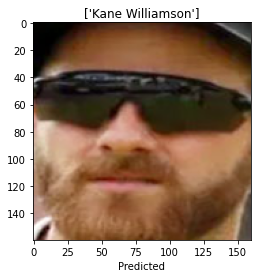

In [12]:
plt.imshow(face)

predicted_label = out_encode.inverse_transform(predictions)

plt.xlabel('Predicted')
plt.title(predicted_label)
print('predicted_label', predicted_label)
print('Confidence :', confidence)